In [2]:
# Import necessary libraries
import sys
import os
import time
import gc
import random
from datetime import datetime, timedelta

# Importing the necessary libraries for data manipulation, machine learning, and visualization
import pandas as pd
import numpy as np
import sklearn
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import mlflow
import mlflow.pytorch
from workalendar.europe import Netherlands

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.mixture import GaussianMixture

import joblib

raw_path = '../data/raw/'
processed_path = '../data/processed/'
image_path = '../reports/figures/'

sys.path.append(raw_path)

C:\Users\20235149\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Read the files

In [11]:
# We want to monitor the performance of our data loading step
start_time = time.time()
print("Loading data from Feather file...")

try:
    df_metered_monthly = feather.read_feather(processed_path + "df_metered_monthly_500_balanced.feather")
    df_unmetered_monthly = feather.read_feather(processed_path + "df_unmetered_monthly_500_balanced.feather")
    print("Feather file loaded successfully")
except Exception as e:
    # Error handling to catch any issues that occur during the loading process
    print(f"Error loading Feather file: {e}")

end_time = time.time()
load_time = end_time - start_time

# Print the time taken to load the data for performance monitoring
print(f"Time taken to load data: {load_time:.2f} seconds")

Loading data from Feather file...
Feather file loaded successfully
Time taken to load data: 4.97 seconds


## Intiliase Model With Training Parameters

In [17]:
# Energy Dataset Class Definition
# Define the dataset class for handling energy consumption data. This will be used to load and preprocess the data.
class EnergyDataset(Dataset):
    def __init__(self, data, max_consumption):
        self.data = data
        self.max_consumption = max_consumption

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor([self.data.iloc[idx]['consumption_normalized']], dtype=torch.float32)
        time_int = int(self.data.iloc[idx]['time_int'])
        month_numeric = int(self.data.iloc[idx]['month'])
        day_of_week = self.data.iloc[idx]['day_of_week']
        day_of_year = self.data.iloc[idx]['day_of_year']
        is_weekend = int(self.data.iloc[idx]['is_weekend'])
        high_tariff = self.data.iloc[idx]['high_tariff']
        consumption_monthly_avg_normalized = self.data.iloc[idx]['consumption_monthly_avg_normalized']
        consumption_monthly_max_normalized = self.data.iloc[idx]['consumption_monthly_max_normalized']
        
        # Extract one-hot encoded values
        total_bin_values = self.data.iloc[idx][self.data.columns.str.startswith('total_bin_')].to_numpy(dtype=np.float32)
        baseload_values = self.data.iloc[idx][self.data.columns.str.startswith('baseload_')].to_numpy(dtype=np.float32)
        
        # Combine all features
        c = torch.tensor([time_int, month_numeric, day_of_week, day_of_year, is_weekend, high_tariff, 
                          consumption_monthly_avg_normalized, consumption_monthly_max_normalized], dtype=torch.float32)
        c = torch.cat((c, torch.tensor(total_bin_values, dtype=torch.float32), torch.tensor(baseload_values, dtype=torch.float32)))
        
        return {'x': x, 'c': c}

# Load and preprocess the data
# Here we define the maximum consumption for normalization purposes.
max_consumption = df_metered_monthly['consumption'].max()

# Create datasets
unmetered_dataset = EnergyDataset(df_unmetered_monthly, max_consumption)
metered_dataset = EnergyDataset(df_metered_monthly, max_consumption)

# Create data loaders for batch processing
train_loader = DataLoader(metered_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(unmetered_dataset, batch_size=64, shuffle=False)

# Define the CVAE model
class CVAE(nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim):
        super(CVAE, self).__init__()
        # Define layers with layer normalization and dropout for better training stability
        self.fc1 = nn.Linear(input_dim + condition_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc21 = nn.Linear(128, latent_dim)
        self.fc22 = nn.Linear(128, latent_dim)
        self.fc3 = nn.Linear(latent_dim + condition_dim, 128)
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, input_dim)
        self.layer_norm1 = nn.LayerNorm(256)
        self.layer_norm2 = nn.LayerNorm(128)
        self.layer_norm3 = nn.LayerNorm(latent_dim)
        self.layer_norm4 = nn.LayerNorm(128)
        self.layer_norm5 = nn.LayerNorm(256)
        self.dropout = nn.Dropout(0.3)
        self.init_weights()

    def init_weights(self):
        # Initialize weights for better convergence
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.01)
                if m.bias is not None:
                    m.bias.data.fill_(0.01)

    def encode(self, x, c):
        # Encode the input and conditions to latent space
        h1 = torch.relu(self.layer_norm1(self.fc1(torch.cat([x, c], dim=1))))
        h1 = self.dropout(h1)
        h2 = torch.relu(self.layer_norm2(self.fc2(h1)))
        h2 = self.dropout(h2)
        mu = self.fc21(h2)
        logvar = self.fc22(h2)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick to sample z
        logvar_clamped = torch.clamp(logvar, min=-10, max=10)
        std = torch.exp(0.5 * logvar_clamped)
        eps = torch.randn_like(std) * 1e-6
        z = mu + eps * std
        return z

    def decode(self, z, c):
        # Decode z and conditions to reconstruct the input
        h3 = torch.relu(self.layer_norm4(self.fc3(torch.cat([z, c], dim=1))))
        h3 = self.dropout(h3)
        h4 = torch.relu(self.layer_norm5(self.fc4(h3)))
        h4 = self.dropout(h4)
        recon = torch.sigmoid(self.fc5(h4))
        return recon

    def forward(self, x, c):
        # Forward pass through the network
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, c)
        return recon, mu, logvar
        
# MMD Calculation Function
# Define the function to compute Maximum Mean Discrepancy (MMD).   
def compute_mmd(x, y, sigma_squares=[1, 2, 4, 8, 16]):
    mmd = 0
    for sigma_square in sigma_squares:
        gamma = 1 / (2 * sigma_square)
        K_XX = torch.exp(-gamma * torch.cdist(x, x, p=2))
        K_YY = torch.exp(-gamma * torch.cdist(y, y, p=2))
        K_XY = torch.exp(-gamma * torch.cdist(x, y, p=2))
        mmd += (K_XX.mean() + K_YY.mean() - 2 * K_XY.mean())
    return mmd
    
# Loss Function Definition
# Define the loss function combining MSE, MMD, and KLD.
def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    z = mu + torch.randn_like(mu) * torch.exp(0.5 * logvar)  # Reparameterization trick
    prior_z = torch.randn_like(z)  # Sample from standard normal distribution

    MMD = compute_mmd(z, prior_z)
    MMD = torch.clamp(MMD, min=0)  # Ensure MMD is non-negative

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + MMD + KLD

# Initialize model, optimizer, and set learning rate
# Here we define the input dimensions, condition dimensions, latent space dimensions, and learning rate.
input_dim = 1
condition_dim = 8 + len(df_metered_monthly.columns[df_metered_monthly.columns.str.startswith('total_bin_')]) + len(df_metered_monthly.columns[df_metered_monthly.columns.str.startswith('baseload_')])
latent_dim = 50
lr = 1e-4

# Determine the device to be used for training (GPU if available, otherwise CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the CVAE model and load pre-trained weights.
model = CVAE(input_dim, condition_dim, latent_dim).to(device)
model.load_state_dict(torch.load('cvae_model_epoch_13_no_attention_ .pth'))

<All keys matched successfully>

## Encode Training Data

In [11]:
model_name = f"cvae_model_layers{model.fc1.out_features}-{model.fc2.out_features}_latent_{latent_dim}_conds_{condition_dim}_no_attention"

In [ ]:
# Function to encode data
# This function encodes the data using the trained CVAE model to obtain latent space representations.

def encode_data(model, loader, device):
    model.eval()
    latent_vectors = []
    condition_vectors = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Encoding training data", leave=True):
            x, c = batch['x'].to(device), batch['c'].to(device)
            mu, logvar = model.encode(x, c)
            z = model.reparameterize(mu, logvar)
            latent_vectors.append(z)
            condition_vectors.append(c)

    return latent_vectors, condition_vectors

# Encode the training data to obtain latent space representations
# Using the trained model and DataLoader, we encode the training data to extract latent vectors and their corresponding condition vectors.
latent_vectors, condition_vectors = encode_data(model, train_loader, device)

In [ ]:
# Concatenate latent vectors and conditions
latent_vectors = torch.cat(latent_vectors, dim=0).cpu().numpy()  # Move to CPU once after concatenation

In [6]:
# Delete unused objects to save memory
del df_metered_monthly
del metered_dataset

In [7]:
condition_vectors = torch.cat(condition_vectors, dim=0).cpu().numpy()  # Move to CPU once after concatenation
latent_cond_vectors = np.concatenate((latent_vectors, condition_vectors), axis=1)

#### Save Latent Vectors for later use if desired (they are large <5gb even for smaller (~500 customers) datasets)

In [10]:
# # Save the latent vectors
latent_vectors_file_path = f"latent_vectors_{model_name}.npy"
np.save(latent_vectors_file_path, latent_vectors)
print(f"Latent vectors saved to {latent_vectors_file_path}")

# Save the latent vectors
latent_cond_vectors_file_path = f"latent_cond_vectors{model_name}.npy"
np.save(latent_cond_vectors_file_path, latent_cond_vectors)
print(f"Latent vectors saved to {latent_vectors_file_path}")

Latent vectors saved to latent_vectors_cvae_model_layers256-128_latent_50_conds_111_no_attention.npy
Latent vectors saved to latent_vectors_cvae_model_layers256-128_latent_50_conds_111_no_attention.npy


In [14]:
latent_cond_vectors_file_path

'latent_cond_vectorscvae_model_layers256-128_latent_50_conds_111_no_attention.npy'

In [11]:
# Delete unused objects to save memory
del condition_vectors
del latent_vectors

In [30]:
# Load the latent vectors
latent_vectors = np.load("latent_vectors_cvae_model_layers256-128_latent_50_conds_111_no_attention.npy")

In [2]:
# Define the file path
latent_cond_vectors_file_path = "latent_cond_vectorscvae_model_layers256-128_latent_50_conds_111_no_attention.npy"

# Load the latent vectors
latent_cond_vectors = np.load(latent_cond_vectors_file_path)

# Print the shape of the loaded latent vectors to verify
print(f"Latent vectors loaded from {latent_cond_vectors_file_path}")
print(f"Shape of latent vectors: {latent_cond_vectors.shape}")

Latent vectors loaded from latent_cond_vectorscvae_model_layers256-128_latent_50_conds_111_no_attention.npy
Shape of latent vectors: (15768000, 161)


##### Fitting Gaussian Mixture Model (GMM) to Latent Conditional & Consumption Vectors

In [ ]:
# Define the number of components for the GMM
n_components = 20

# Initialize the GMM with the specified number of components
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)

# Fit the GMM to the latent conditional+consumption vectors
gmm.fit(latent_cond_vectors)

# Print a message indicating the GMM has been fitted successfully
print(f"GMM fitted with {n_components} components")

In [ ]:
import joblib

# Save the GMM using joblib
gmm_file_path = f"gmm_model_{model_name}_comps_{n_components}-cond_gmm_balanced.joblib"
joblib.dump(gmm, gmm_file_path)
print(f"GMM model saved to {gmm_file_path}")

In [101]:
# Delete unused objects to save memory
del latent_cond_vectors
del df_metered_monthly

## Reconstruct Test Data

In [21]:
df_unmetered_monthly['RND_ID'].unique()

array(['9655', '12332', '11500', '4247', '5261', '10341', '4873', '2607',
       '769', '5562', '5445', '2212', '2081', '1241', '3515', '10938',
       '7313', '5383', '2748', '12066', '5918', '10042', '5486', '9599',
       '706', '1738', '7405', '3771', '966', '4964', '1531', '2068',
       '6388', '2562', '9596', '10569', '2060', '12885', '11510', '1358',
       '7259', '3551', '8383', '6315', '6357', '727', '7397', '5098',
       '6975', '4731'], dtype=object)

### Filter test dataset for more faster testing if desired

In [19]:
# Selected RND_IDs
selected_rnd_ids = ['9655', '12332', '11500', '4247', '5261', '10341']

# Filter the dataset to include only selected RND_IDs
df_unmetered_filtered = df_unmetered_monthly[(df_unmetered_monthly['RND_ID'].isin(selected_rnd_ids)) & (df_unmetered_monthly['month'].isin([1]))].reset_index()
df_unmetered_filtered

index RND_ID Connection category  avg_consumption  \
0            6   9655                AC4B         0.000000   
1           15  12332                AC4B        23.965846   
2           17  11500                AC4B         5.910202   
3           29   9655                AC4B         0.000000   
4           38  12332                AC4B        23.965846   
...        ...    ...                 ...              ...   
17851  1521575  10341                AC4A         8.786368   
17852  1521580  10341                AC4A         8.786368   
17853  1521585  10341                AC4A         8.786368   
17854  1521590  10341                AC4A         8.786368   
17855  1521595  10341                AC4A         8.786368   

       consumption_quantile           timestamp  consumption  high_tariff  \
0                         0 2023-01-01 00:00:00          0.0            0   
1                         4 2023-01-01 00:00:00         12.0            0   
2                         1 2023-01-01 00:00:00          0.0            0   
3                         0 2023-01-01 00:15:00          0.0            0   
4                         4 2023-01-01 00:15:00         12.0            0   
...                     ...                 ...          ...          ...   
17851                     2 2023-01-31 22:45:00          4.0            0   
17852                     2 2023-01-31 23:00:00          4.0            0   
17853                     2 2023-01-31 23:15:00          0.0            0   
17854                     2 2023-01-31 23:30:00          4.0            0   
17855                     2 2023-01-31 23:45:00          4.0            0   

       hour  day_of_week  ...  baseload_016  baseload_017  baseload_018  \
0         0            6  ...         False         False         False   
1         0            6  ...         False         False         False   
2         0            6  ...         False         False         False   
3         0            6  ...         False         False         False   
4         0            6  ...         False         False         False   
...     ...          ...  ...           ...           ...           ...   
17851    22            1  ...         False         False         False   
17852    23            1  ...         False         False         False   
17853    23            1  ...         False         False         False   
17854    23            1  ...         False         False         False   
17855    23            1  ...         False         False         False   

       baseload_019  baseload_020  baseload_E3A  baseload_E3B  baseload_E3C  \
0             False         False         False         False         False   
1             False         False         False         False         False   
2             False         False         False         False         False   
3             False         False         False         False         False   
4             False         False         False         False         False   
...             ...           ...           ...           ...           ...   
17851         False         False         False         False         False   
17852         False         False         False         False         False   
17853         False         False         False         False         False   
17854         False         False         False         False         False   
17855         False         False         False         False         False   

       baseload_E3D  Baseload_profile  
0             False               001  
1             False               001  
2             False               001  
3             False               001  
4             False               001  
...             ...               ...  
17851         False               006  
17852         False               006  
17853         False               006  
17854         False               006  
17855         False               006  

[17856 r

In [24]:
# Create datasets
unmetered_dataset = EnergyDataset(df_unmetered_filtered, max_consumption)
# metered_dataset = EnergyDataset(df_metered_monthly, max_consumption)

# Create data loaders for batch processing
# train_loader = DataLoader(metered_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(unmetered_dataset, batch_size=64, shuffle=False)

In [27]:
# Conditional Sampling from GMM
# This function performs conditional sampling from a Gaussian Mixture Model (GMM) given a condition vector 'c' and the number of samples 'num_samples'.
def conditional_sampling(gmm, c, num_samples):
    c_repeated = np.tile(c, (num_samples, 1))  # Repeat condition for each sample
    latent_cond_samples, _ = gmm.sample(num_samples)
    
    # Split the samples to get latent vectors
    z_samples = latent_cond_samples[:, :latent_vectors.shape[1]]
    return z_samples, c_repeated

#### Use the GMM to sample the latent space during inference


In [25]:
# Load the pre-trained Gaussian Mixture Model (GMM)
import joblib

# Define the path to the saved GMM file
gmm_path = "gmm_model_cvae_model_layers256-128_latent_50_conds_111_no_attention_comps_20-cond_gmm_balanced.joblib"

# Load the GMM
gmm = joblib.load(gmm_path)
print("GMM loaded successfully")


GMM loaded successfully


In [31]:
# During inference, we use the GMM to generate samples from the latent space, conditionally reconstruct the data, and estimate reconstruction uncertainty.
reconstructed_data = []
reconstruction_uncertainty = []
true_consumption = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Reconstructing test data"):
        x, c = batch['x'].to(device), batch['c'].to(device)
        true_consumption.append(x.cpu().numpy())
        
        # Sample latent vectors conditionally
        n_samples = 10
        z_samples, c_samples = conditional_sampling(gmm, c.cpu().numpy(), c.shape[0] * n_samples)
        
        # Reconstruct multiple times
        recon_samples = []
        for i in range(n_samples):
            z_batch = torch.tensor(z_samples[i * c.shape[0]:(i + 1) * c.shape[0]], dtype=torch.float32).to(device)
            c_batch = torch.tensor(c_samples[i * c.shape[0]:(i + 1) * c.shape[0]], dtype=torch.float32).to(device)
            recon_batch = model.decode(z_batch, c_batch)
            recon_samples.append(recon_batch)
        
        # Calculate mean and standard deviation of reconstructions
        recon_samples = torch.stack(recon_samples)
        recon_mean = recon_samples.mean(dim=0)
        recon_std = recon_samples.std(dim=0)
        
        reconstructed_data.append(recon_mean.cpu().numpy())
        reconstruction_uncertainty.append(recon_std.cpu().numpy())

# Convert the reconstructed data and uncertainty to NumPy arrays
reconstructed_data = np.concatenate(reconstructed_data)
reconstruction_uncertainty = np.concatenate(reconstruction_uncertainty)
true_consumption = np.concatenate(true_consumption)

Reconstructing test data: 100%|██████████████████████████████████████████████████████| 279/279 [02:48<00:00,  1.66it/s]


In [32]:
# Calculate metrics
# In this section, we calculate the performance metrics of the reconstructed data against the true consumption data.

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_consumption, reconstructed_data)
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(true_consumption, reconstructed_data)
# Calculate R-squared (R2)
r2 = r2_score(true_consumption, reconstructed_data)
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print the calculated metrics
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')
print(f'RMSE: {rmse}')

# Convert the reconstructed data to a DataFrame
# We create a DataFrame to store the reconstructed consumption and its uncertainty.
df_reconstructed = pd.DataFrame({
    'Reconstructed_Consumption': reconstructed_data.flatten(),
    'Reconstruction_Uncertainty': reconstruction_uncertainty.flatten()
})

# Remove the specified columns
# We drop the columns related to binning and baseload profiles from the unmetered data to reduce it's size
columns_to_remove = df_unmetered_filtered.columns[df_unmetered_filtered.columns.str.startswith('total_bin_') | 
                                                 df_unmetered_filtered.columns.str.startswith('baseload_')]
df_unmetered_filtered = df_unmetered_filtered.drop(columns=columns_to_remove)

# Concatenate the reconstructed data
# We concatenate the reconstructed data with the unmetered data to form a complete DataFrame.
df_unmetered_filtered = pd.concat([df_unmetered_filtered, df_reconstructed], axis=1)


MSE: 0.0016776459524407983
MAE: 0.027345728129148483
R2: 0.7300908644673965
RMSE: 0.04095907509326935


### Add 'Datetime'

In [55]:
# Ensure the 'day_of_year' and 'hour' columns are properly formatted as strings
df_unmetered_filtered['day_of_year'] = df_unmetered_filtered['day_of_year'].astype(int).astype(str).str.zfill(3)
df_unmetered_filtered['hour'] = df_unmetered_filtered['hour'].astype(int).astype(str).str.zfill(2)

# Create the 'Datetime' column
df_unmetered_filtered['Datetime'] = pd.to_datetime('2023 ' + df_unmetered_filtered['day_of_year'] + ' ' + df_unmetered_filtered['hour'], format='%Y %j %H')

# Downsample the data
df_unmetered_filtered.set_index('Datetime', inplace=True)

# Create the 'Datetime' column again
df_unmetered_filtered['Datetime'] = pd.to_datetime('2023 ' + df_unmetered_filtered['day_of_year'] + ' ' + df_unmetered_filtered['hour'], format='%Y %j %H')

In [39]:
df_unmetered_filtered['Reconstructed_Consumption_unnorm'] = df_unmetered_filtered['Reconstructed_Consumption']*184

In [40]:
df_unmetered_filtered

index RND_ID Connection category  avg_consumption  \
Datetime                                                                   
2023-01-01 00:00:00        6   9655                AC4B         0.000000   
2023-01-01 00:00:00       15  12332                AC4B        23.965846   
2023-01-01 00:00:00       17  11500                AC4B         5.910202   
2023-01-01 00:00:00       29   9655                AC4B         0.000000   
2023-01-01 00:00:00       38  12332                AC4B        23.965846   
...                      ...    ...                 ...              ...   
2023-01-31 22:00:00  1521575  10341                AC4A         8.786368   
2023-01-31 23:00:00  1521580  10341                AC4A         8.786368   
2023-01-31 23:00:00  1521585  10341                AC4A         8.786368   
2023-01-31 23:00:00  1521590  10341                AC4A         8.786368   
2023-01-31 23:00:00  1521595  10341                AC4A         8.786368   

                     consumption_quantile           timestamp  consumption  \
Datetime                                                                     
2023-01-01 00:00:00                     0 2023-01-01 00:00:00          0.0   
2023-01-01 00:00:00                     4 2023-01-01 00:00:00         12.0   
2023-01-01 00:00:00                     1 2023-01-01 00:00:00          0.0   
2023-01-01 00:00:00                     0 2023-01-01 00:15:00          0.0   
2023-01-01 00:00:00                     4 2023-01-01 00:15:00         12.0   
...                                   ...                 ...          ...   
2023-01-31 22:00:00                     2 2023-01-31 22:45:00          4.0   
2023-01-31 23:00:00                     2 2023-01-31 23:00:00          4.0   
2023-01-31 23:00:00                     2 2023-01-31 23:15:00          0.0   
2023-01-31 23:00:00                     2 2023-01-31 23:30:00          4.0   
2023-01-31 23:00:00                     2 2023-01-31 23:45:00          4.0   

                     high_tariff hour  day_of_week  ...  \
Datetime                                            ...   
2023-01-01 00:00:00            0   00            6  ...   
2023-01-01 00:00:00            0   00            6  ...   
2023-01-01 00:00:00            0   00            6  ...   
2023-01-01 00:00:00            0   00            6  ...   
2023-01-01 00:00:00            0   00            6  ...   
...                          ...  ...          ...  ...   
2023-01-31 22:00:00            0   22            1  ...   
2023-01-31 23:00:00            0   23            1  ...   
2023-01-31 23:00:00            0   23            1  ...   
2023-01-31 23:00:00            0   23            1  ...   
2023-01-31 23:00:00            0   23            1  ...   

                     consumption_yearly_total  consumption_normalized  \
Datetime                                                                
2023-01-01 00:00:00                      0.00                0.000000   
2023-01-01 00:00:00                 839763.24                0.065217   
2023-01-01 00:00:00                 207093.49                0.000000   
2023-01-01 00:00:00                      0.00                0.000000   
2023-01-01 00:00:00                 839763.24                0.065217   
...                                       ...                     ...   
2023-01-31 22:00:00                 307874.32                0.021739   
2023-01-31 23:00:00                 307874.32                0.021739   
2023-01-31 23:00:00                 307874.32                0.000000   
2023-01-31 23:00:00                 307874.32                0.021739   
2023-01-31 23:00:00                 307874.32                0.021739   

                     consumption_monthly_total_normalized  \
Datetime                                                    
2023-01-01 00:00:00                              0.000000   
2023-01-01 00:00:00                              0.439364   
2023-01-01 00:00:00                              0.128082

### Plot actual vs. reconstructed consumption
Visualization of Reconstructed Consumption


MSE: 14.476317908158757, MAE: 3.0313865632139225


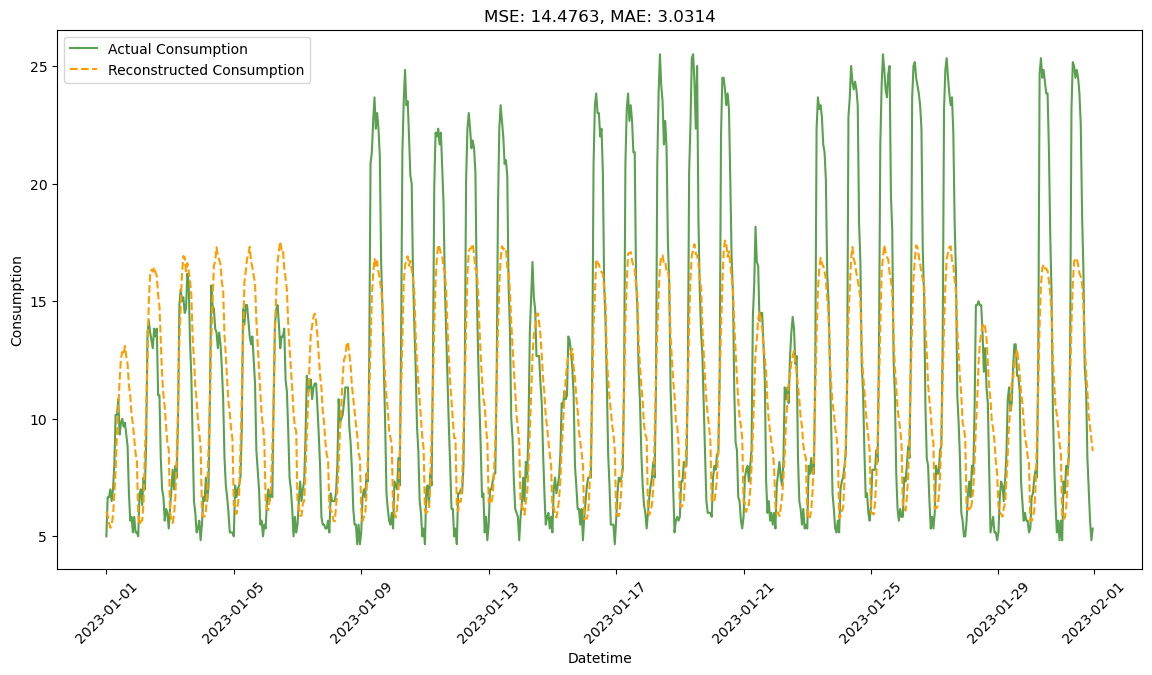

In [42]:
# Define the color palette from the provided image
actual_color = '#59A14F'  # Green
reconstructed_color = '#FF9D00'  # Orange

selected_rnd_id = 1998  # Change this as needed

df_selected = df_unmetered_filtered#[(df_unmetered_monthly['month'].isin([1]))]

# Select only numeric columns for resampling
numeric_cols = df_selected.select_dtypes(include=[np.number]).columns
df_downsampled = df_selected[numeric_cols].resample('h').mean().reset_index()

# Plot the downsampled data
if 'consumption_normalized' in df_downsampled.columns:
    # Calculate the error metrics (e.g., MSE, MAE)
    mse = ((df_downsampled['consumption'] - df_downsampled['Reconstructed_Consumption']) ** 2).mean()
    mae = (df_downsampled['consumption'] - df_downsampled['Reconstructed_Consumption']).abs().mean()

    print(f'MSE: {mse}, MAE: {mae}')

    # Plot actual vs. reconstructed consumption using the datetime values
    plt.figure(figsize=(14, 7))
    plt.plot(df_downsampled['Datetime'].values, df_downsampled['consumption'].values, label='Actual Consumption', color=actual_color)
    plt.plot(df_downsampled['Datetime'].values, df_downsampled['Reconstructed_Consumption'].values, label='Reconstructed Consumption', linestyle='--', color=reconstructed_color)
    plt.xlabel('Datetime')
    plt.ylabel('Consumption')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.title(f'MSE: {mse:.4f}, MAE: {mae:.4f}')
    plt.show()
else:
    print("Actual consumption data is not available for comparison.")

In [56]:
combined_df = df_unmetered_filtered

One Day - MSE: 32.91617874963689, MAE: 5.18770694732666, MMD: 1.6467722654342651
One Week - MSE: 27.561844586774946, MAE: 4.6792638926278975, MMD: 1.3945988416671753
One Month - MSE: 31.72440481166308, MAE: 5.087767451681117, MMD: 1.2814885377883911


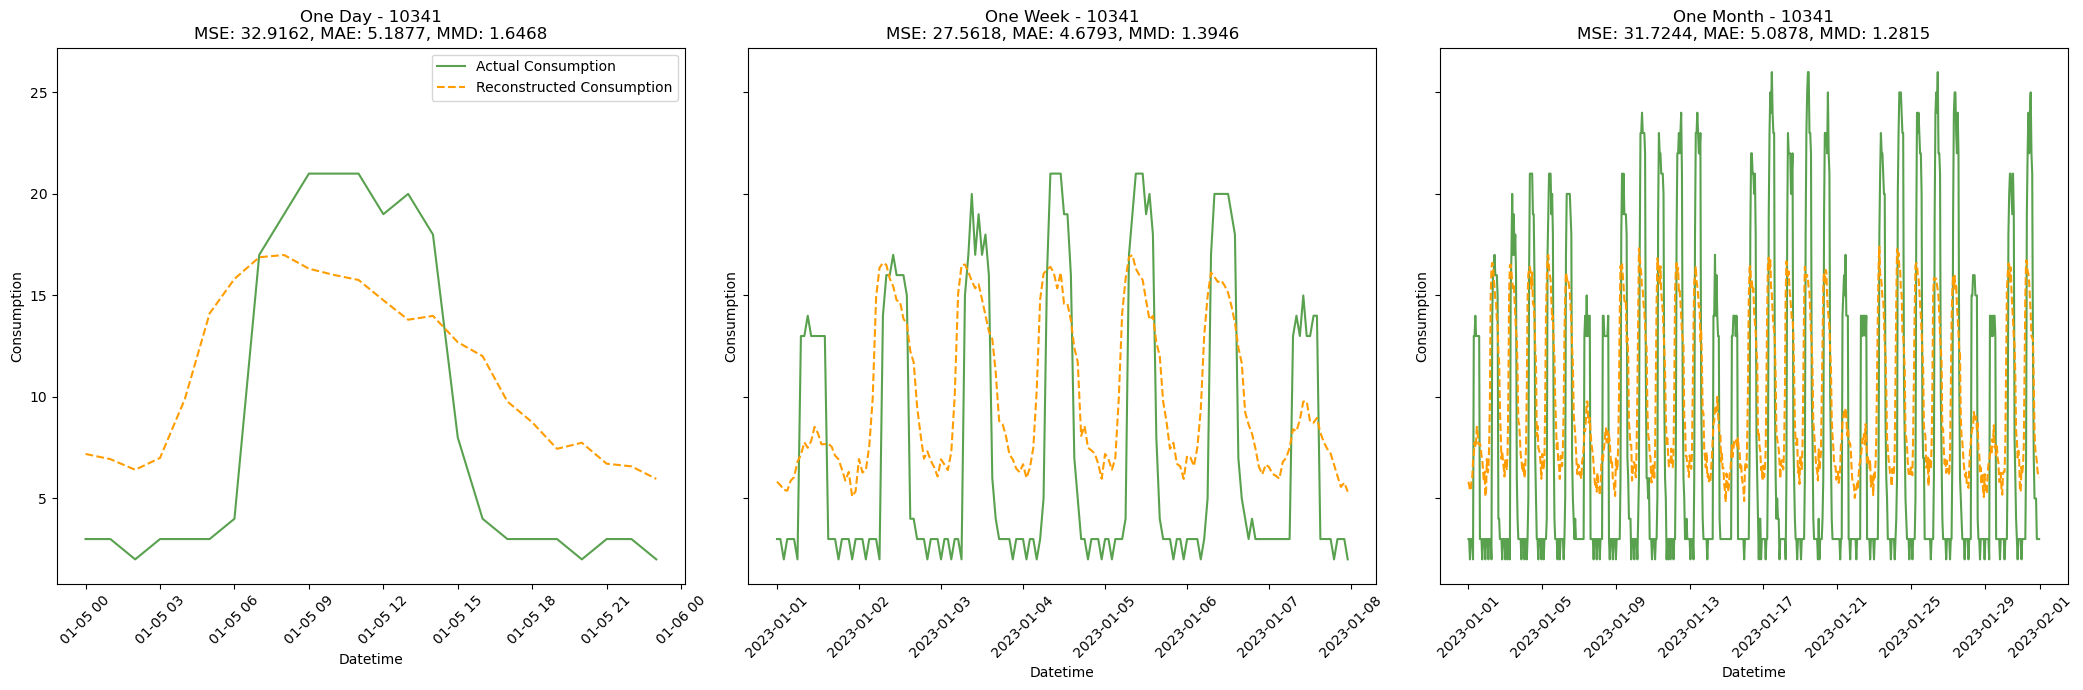

In [52]:
# Define the color palette from the provided image
actual_color = '#59A14F'  # Green
reconstructed_color = '#FF9D00'  # Orange

# Function to compute Maximum Mean Discrepancy (MMD)
def compute_mmd(x, y, sigma_squares=[1, 2, 4, 8, 16]):
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    mmd = 0
    for sigma_square in sigma_squares:
        gamma = 1 / (2 * sigma_square)
        K_XX = torch.exp(-gamma * torch.cdist(x_tensor.unsqueeze(1), x_tensor.unsqueeze(1), p=2))
        K_YY = torch.exp(-gamma * torch.cdist(y_tensor.unsqueeze(1), y_tensor.unsqueeze(1), p=2))
        K_XY = torch.exp(-gamma * torch.cdist(x_tensor.unsqueeze(1), y_tensor.unsqueeze(1), p=2))
        mmd += (K_XX.mean() + K_YY.mean() - 2 * K_XY.mean())
    return mmd.item()

selected_rnd_id = "10341"  # Change this as needed

# Define filters for different time levels
filters = {
    'One Day': (combined_df['month'].isin([1])) & (combined_df['RND_ID'].isin([selected_rnd_id])) & (combined_df['day_of_year'].isin(['005'])),
    'One Week': (combined_df['month'].isin([1])) & (combined_df['RND_ID'].isin([selected_rnd_id])) & (combined_df['day_of_year'].isin([str(i).zfill(3) for i in range(1, 8)])),
    'One Month': (combined_df['month'].isin([1])) & (combined_df['RND_ID'].isin([selected_rnd_id]))
}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharey=True)
axes = axes.flatten()

for i, (title, filter_cond) in enumerate(filters.items()):
    df_selected = combined_df[filter_cond]

    # Select only numeric columns for resampling
    numeric_cols = df_selected.select_dtypes(include=[np.number]).columns
    df_downsampled = df_selected[numeric_cols].resample('h').mean().reset_index()

    # Plot the downsampled data
    if 'consumption_normalized' in df_downsampled.columns:
        # Calculate the error metrics (e.g., MSE, MAE)
        mse = ((df_downsampled['consumption'] - df_downsampled['Reconstructed_Consumption']) ** 2).mean()
        mae = (df_downsampled['consumption'] - df_downsampled['Reconstructed_Consumption']).abs().mean()
        
        # Calculate MMD
        mmd = compute_mmd(df_downsampled['consumption'], df_downsampled['Reconstructed_Consumption'])

        print(f'{title} - MSE: {mse}, MAE: {mae}, MMD: {mmd}')

        # Plot actual vs. reconstructed consumption using the datetime values
        axes[i].plot(df_downsampled['Datetime'].values, df_downsampled['consumption'].values, label='Actual Consumption', color=actual_color)
        axes[i].plot(df_downsampled['Datetime'].values, df_downsampled['Reconstructed_Consumption'].values, label='Reconstructed Consumption', linestyle='--', color=reconstructed_color)
        axes[i].set_xlabel('Datetime')
        axes[i].set_ylabel('Consumption')
        axes[i].set_title(f'{title} - {selected_rnd_id}\nMSE: {mse:.4f}, MAE: {mae:.4f}, MMD: {mmd:.4f}')
        axes[i].tick_params(axis='x', rotation=45)

axes[0].legend()
plt.tight_layout()
# Save the plot as a high-resolution image
plt.savefig(image_path + f"reconstructed_consumption_plot_No Attention Yearly Norm_balanced_{selected_rnd_id}.png", dpi=300)
plt.show()

del df_selected
del df_downsampled

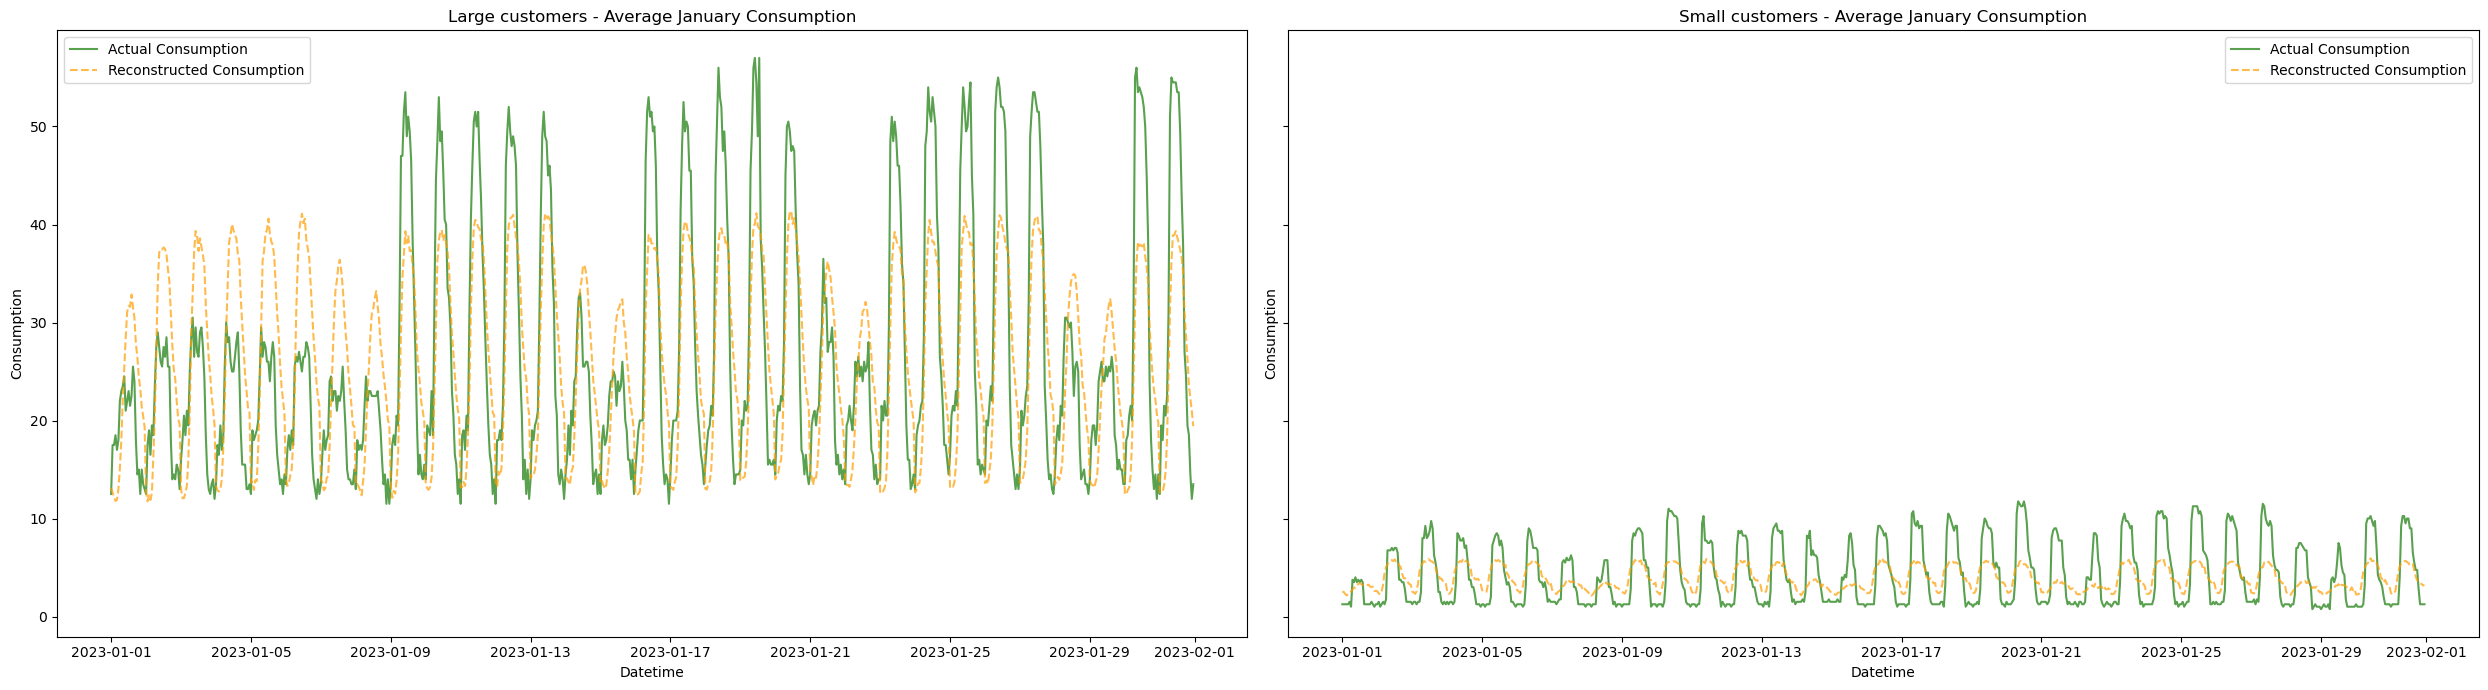

In [58]:
# Define the color palette
actual_color = '#59A14F'  # Green
reconstructed_color_1 = '#FF9D00'  # Orange
reconstructed_color_2 = '#D62828'  # Red
reconstructed_color_3 = '#2D6A4F'  # Dark Green

# Filter for a specific month
month = 1  # Example: January
monthly_df = combined_df[combined_df['month'] == month]

# Separate large and small customers
large_customers = monthly_df.groupby('RND_ID').filter(lambda x: x['consumption'].mean() > 20)
small_customers = monthly_df.groupby('RND_ID').filter(lambda x: x['consumption'].mean() <= 20)

# Ensure 'datetime' is the index for resampling
large_customers.set_index('Datetime', inplace=True)
small_customers.set_index('Datetime', inplace=True)

# Define a function to resample and plot the data
def plot_customer_data(df, title, ax):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_hourly = df[numeric_cols].resample('h').mean().reset_index()
    ax.plot(df_hourly['Datetime'], df_hourly['consumption'], linestyle='-', color=actual_color, alpha=1, label='Actual Consumption')
    ax.plot(df_hourly['Datetime'], df_hourly['Reconstructed_Consumption'], linestyle='--', color=reconstructed_color_1, alpha=0.7, label='Reconstructed Consumption')
    ax.set_title(title)
    ax.set_xlabel('Datetime')
    ax.set_ylabel('Consumption')
    ax.legend()

# Aggregate hourly data for large customers
fig, axes = plt.subplots(1, 2, figsize=(25, 7), sharey=True)
axes = axes.flatten()

# Plot for large customers
plot_customer_data(large_customers, 'Large customers - Average January Consumption', axes[0])

# Plot for small customers
plot_customer_data(small_customers, 'Small customers - Average January Consumption', axes[1])

plt.tight_layout()
# Save the plot as a high-resolution image
plt.savefig(image_path + "reconstructed_consumption_comparison_avg_january.png", dpi=300)
plt.show()

## Reconstruct Test Data (Full Train Set)

In [70]:
df_unmetered_monthly['RND_ID'].unique()

array(['9655', '12332', '11500', '4247', '5261', '10341', '4873', '2607',
       '769', '5562', '5445', '2212', '2081', '1241', '3515', '10938',
       '7313', '5383', '2748', '12066', '5918', '10042', '5486', '9599',
       '706', '1738', '7405', '3771', '966', '4964', '1531', '2068',
       '6388', '2562', '9596', '10569', '2060', '12885', '11510', '1358',
       '7259', '3551', '8383', '6315', '6357', '727', '7397', '5098',
       '6975', '4731'], dtype=object)

### No filter

In [77]:
# Selected RND_IDs
selected_rnd_ids = ['9655', '12332', '11500', '4247', '5261', '10341']

# Filter the dataset to include only selected RND_IDs
df_unmetered_filtered = df_unmetered_monthly.reset_index()#[(df_unmetered_monthly['RND_ID'].isin(selected_rnd_ids)) & (df_unmetered_monthly['month'].isin([1]))].reset_index()
df_unmetered_filtered

index RND_ID Connection category  avg_consumption  \
0               6   9655                AC4B         0.000000   
1              15  12332                AC4B        23.965846   
2              17  11500                AC4B         5.910202   
3              29   9655                AC4B         0.000000   
4              38  12332                AC4B        23.965846   
...           ...    ...                 ...              ...   
1751995  17519954   4731                AC4A         6.616049   
1751996  17519965   4731                AC4A         6.616049   
1751997  17519976   4731                AC4A         6.616049   
1751998  17519987   4731                AC4A         6.616049   
1751999  17519998   4731                AC4A         6.616049   

         consumption_quantile           timestamp  consumption  high_tariff  \
0                           0 2023-01-01 00:00:00         0.00            0   
1                           4 2023-01-01 00:00:00        12.00            0   
2                           1 2023-01-01 00:00:00         0.00            0   
3                           0 2023-01-01 00:15:00         0.00            0   
4                           4 2023-01-01 00:15:00        12.00            0   
...                       ...                 ...          ...          ...   
1751995                     1 2023-12-31 22:45:00         8.77            0   
1751996                     1 2023-12-31 23:00:00         6.74            0   
1751997                     1 2023-12-31 23:15:00         6.25            0   
1751998                     1 2023-12-31 23:30:00         8.03            0   
1751999                     1 2023-12-31 23:45:00         9.69            0   

         hour  day_of_week  ...  baseload_016  baseload_017  baseload_018  \
0           0            6  ...         False         False         False   
1           0            6  ...         False         False         False   
2           0            6  ...         False         False         False   
3           0            6  ...         False         False         False   
4           0            6  ...         False         False         False   
...       ...          ...  ...           ...           ...           ...   
1751995    22            6  ...         False         False         False   
1751996    23            6  ...         False         False         False   
1751997    23            6  ...         False         False         False   
1751998    23            6  ...         False         False         False   
1751999    23            6  ...         False         False         False   

         baseload_019  baseload_020  baseload_E3A  baseload_E3B  baseload_E3C  \
0               False         False         False         False         False   
1               False         False         False         False         False   
2               False         False         False         False         False   
3               False         False         False         False         False   
4               False         False         False         False         False   
...               ...           ...           ...           ...           ...   
1751995         False         False         False         False         False   
1751996         False         False         False         False         False   
1751997         False         False         False         False         False   
1751998         False         False         False         False         False   
1751999         False         False         False         False         False   

         baseload_E3D  Baseload_profile  
0               False               001  
1               False               001  
2               False               001  
3               False               001  
4               False               001  
...               ...               ...  
1751995          True               E3D  
1751996          True               E3D  
175199

In [71]:
# Create datasets
unmetered_dataset = EnergyDataset(df_unmetered_filtered, max_consumption)
# metered_dataset = EnergyDataset(df_metered_monthly, max_consumption)

# Create data loaders for batch processing
# train_loader = DataLoader(metered_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(unmetered_dataset, batch_size=64, shuffle=False)

In [62]:
# Conditional Sampling from GMM
def conditional_sampling(gmm, c, num_samples):
    c_repeated = np.tile(c, (num_samples, 1))  # Repeat condition for each sample
    latent_cond_samples, _ = gmm.sample(num_samples)
    
    # Split the samples to get latent vectors
    z_samples = latent_cond_samples[:, :latent_vectors.shape[1]]
    return z_samples, c_repeated

In [63]:
# Use the GMM to sample the latent space during inference
reconstructed_data = []
reconstruction_uncertainty = []
true_consumption = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Reconstructing test data"):
        x, c = batch['x'].to(device), batch['c'].to(device)
        true_consumption.append(x.cpu().numpy())
        
        # Sample latent vectors conditionally
        n_samples = 10
        z_samples, c_samples = conditional_sampling(gmm, c.cpu().numpy(), c.shape[0] * n_samples)
        
        # Reconstruct multiple times
        recon_samples = []
        for i in range(n_samples):
            z_batch = torch.tensor(z_samples[i * c.shape[0]:(i + 1) * c.shape[0]], dtype=torch.float32).to(device)
            c_batch = torch.tensor(c_samples[i * c.shape[0]:(i + 1) * c.shape[0]], dtype=torch.float32).to(device)
            recon_batch = model.decode(z_batch, c_batch)
            recon_samples.append(recon_batch)
        
        # Calculate mean and standard deviation of reconstructions
        recon_samples = torch.stack(recon_samples)
        recon_mean = recon_samples.mean(dim=0)
        recon_std = recon_samples.std(dim=0)
        
        reconstructed_data.append(recon_mean.cpu().numpy())
        reconstruction_uncertainty.append(recon_std.cpu().numpy())

# Convert the reconstructed data and uncertainty to NumPy arrays
reconstructed_data = np.concatenate(reconstructed_data)
reconstruction_uncertainty = np.concatenate(reconstruction_uncertainty)
true_consumption = np.concatenate(true_consumption)

Reconstructing test data: 100%|████████████████████████████████████████████████| 27375/27375 [5:41:51<00:00,  1.33it/s]


In [78]:
# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(true_consumption, reconstructed_data)
mae = mean_absolute_error(true_consumption, reconstructed_data)
r2 = r2_score(true_consumption, reconstructed_data)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')
print(f'RMSE: {rmse}')

# Convert the reconstructed data to a DataFrame
df_reconstructed = pd.DataFrame({
    'Reconstructed_Consumption': reconstructed_data.flatten(),
    'Reconstruction_Uncertainty': reconstruction_uncertainty.flatten()
})

# Remove the specified columns
columns_to_remove = df_unmetered_filtered.columns[df_unmetered_filtered.columns.str.startswith('total_bin_') | 
                                                 df_unmetered_filtered.columns.str.startswith('baseload_')]
df_unmetered_filtered = df_unmetered_filtered.drop(columns=columns_to_remove)

# Concatenate the reconstructed data
df_unmetered_filtered = pd.concat([df_unmetered_filtered, df_reconstructed], axis=1)

MSE: 0.0019327837508171797
MAE: 0.02699350006878376
R2: 0.7022700075781079
RMSE: 0.04396343603730202


### Add 'Datetime'

In [80]:
# Ensure the 'day_of_year' and 'hour' columns are properly formatted as strings
df_unmetered_filtered['day_of_year'] = df_unmetered_filtered['day_of_year'].astype(int).astype(str).str.zfill(3)
df_unmetered_filtered['hour'] = df_unmetered_filtered['hour'].astype(int).astype(str).str.zfill(2)

# Create the 'Datetime' column
df_unmetered_filtered['Datetime'] = pd.to_datetime('2023 ' + df_unmetered_filtered['day_of_year'] + ' ' + df_unmetered_filtered['hour'], format='%Y %j %H')

# Downsample the data
df_unmetered_filtered.set_index('Datetime', inplace=True)

In [84]:
df_unmetered_filtered['Reconstructed_Consumption_unnorm'] = df_unmetered_filtered['Reconstructed_Consumption']*184

In [85]:
df_unmetered_filtered

index RND_ID Connection category  avg_consumption  \
Datetime                                                                    
2023-01-01 00:00:00         6   9655                AC4B         0.000000   
2023-01-01 00:00:00        15  12332                AC4B        23.965846   
2023-01-01 00:00:00        17  11500                AC4B         5.910202   
2023-01-01 00:00:00        29   9655                AC4B         0.000000   
2023-01-01 00:00:00        38  12332                AC4B        23.965846   
...                       ...    ...                 ...              ...   
2023-12-31 22:00:00  17519954   4731                AC4A         6.616049   
2023-12-31 23:00:00  17519965   4731                AC4A         6.616049   
2023-12-31 23:00:00  17519976   4731                AC4A         6.616049   
2023-12-31 23:00:00  17519987   4731                AC4A         6.616049   
2023-12-31 23:00:00  17519998   4731                AC4A         6.616049   

                     consumption_quantile           timestamp  consumption  \
Datetime                                                                     
2023-01-01 00:00:00                     0 2023-01-01 00:00:00         0.00   
2023-01-01 00:00:00                     4 2023-01-01 00:00:00        12.00   
2023-01-01 00:00:00                     1 2023-01-01 00:00:00         0.00   
2023-01-01 00:00:00                     0 2023-01-01 00:15:00         0.00   
2023-01-01 00:00:00                     4 2023-01-01 00:15:00        12.00   
...                                   ...                 ...          ...   
2023-12-31 22:00:00                     1 2023-12-31 22:45:00         8.77   
2023-12-31 23:00:00                     1 2023-12-31 23:00:00         6.74   
2023-12-31 23:00:00                     1 2023-12-31 23:15:00         6.25   
2023-12-31 23:00:00                     1 2023-12-31 23:30:00         8.03   
2023-12-31 23:00:00                     1 2023-12-31 23:45:00         9.69   

                     high_tariff hour  day_of_week  ...  \
Datetime                                            ...   
2023-01-01 00:00:00            0   00            6  ...   
2023-01-01 00:00:00            0   00            6  ...   
2023-01-01 00:00:00            0   00            6  ...   
2023-01-01 00:00:00            0   00            6  ...   
2023-01-01 00:00:00            0   00            6  ...   
...                          ...  ...          ...  ...   
2023-12-31 22:00:00            0   22            6  ...   
2023-12-31 23:00:00            0   23            6  ...   
2023-12-31 23:00:00            0   23            6  ...   
2023-12-31 23:00:00            0   23            6  ...   
2023-12-31 23:00:00            0   23            6  ...   

                     consumption_yearly_total  consumption_normalized  \
Datetime                                                                
2023-01-01 00:00:00                      0.00                0.000000   
2023-01-01 00:00:00                 839763.24                0.065217   
2023-01-01 00:00:00                 207093.49                0.000000   
2023-01-01 00:00:00                      0.00                0.000000   
2023-01-01 00:00:00                 839763.24                0.065217   
...                                       ...                     ...   
2023-12-31 22:00:00                 231826.34                0.047663   
2023-12-31 23:00:00                 231826.34                0.036630   
2023-12-31 23:00:00                 231826.34                0.033967   
2023-12-31 23:00:00                 231826.34                0.043641   
2023-12-31 23:00:00                 231826.34                0.052663   

                     consumption_monthly_total_normalized  \
Datetime                                                    
2023-01-01 00:00:00                              0.000000   
2023-01-01 00:00:00                              0.439364   
2023-01-01 00:00:00                          

### Plot actual vs. reconstructed consumption

MSE: 4.1341903354833445, MAE: 1.5458953386774068


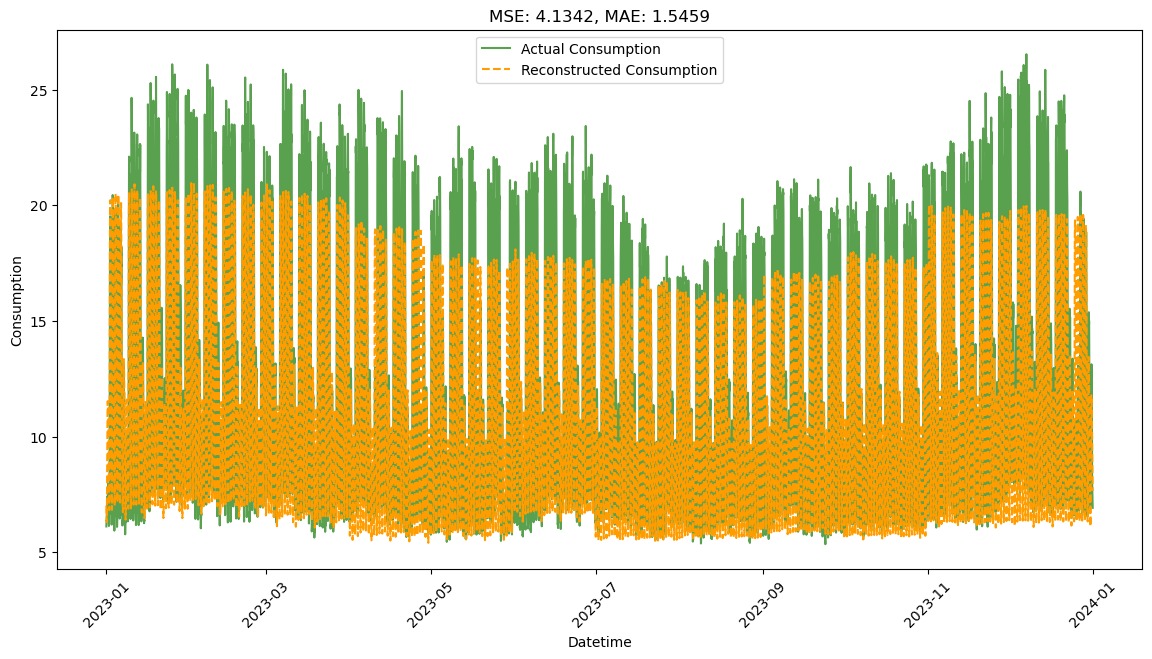

In [87]:
# Define the color palette from the provided image
actual_color = '#59A14F'  # Green
reconstructed_color = '#FF9D00'  # Orange

# Function to compute Maximum Mean Discrepancy (MMD)
def compute_mmd(x, y, sigma_squares=[1, 2, 4, 8, 16]):
    mmd = 0
    for sigma_square in sigma_squares:
        gamma = 1 / (2 * sigma_square)
        K_XX = torch.exp(-gamma * torch.cdist(torch.tensor(x).unsqueeze(1), torch.tensor(x).unsqueeze(1), p=2))
        K_YY = torch.exp(-gamma * torch.cdist(torch.tensor(y).unsqueeze(1), torch.tensor(y).unsqueeze(1), p=2))
        K_XY = torch.exp(-gamma * torch.cdist(torch.tensor(x).unsqueeze(1), torch.tensor(y).unsqueeze(1), p=2))
        mmd += (K_XX.mean() + K_YY.mean() - 2 * K_XY.mean())
    return mmd.item()

selected_rnd_id = 1998  # Change this as needed

df_selected = df_unmetered_filtered#[(df_unmetered_monthly['month'].isin([1]))]

# Select only numeric columns for resampling
numeric_cols = df_selected.select_dtypes(include=[np.number]).columns
df_downsampled = df_selected[numeric_cols].resample('h').mean().reset_index()

# Plot the downsampled data
if 'consumption_normalized' in df_downsampled.columns:
    # Calculate the error metrics (e.g., MSE, MAE)
    mse = ((df_downsampled['consumption'] - df_downsampled['Reconstructed_Consumption_unnorm']) ** 2).mean()
    mae = (df_downsampled['consumption'] - df_downsampled['Reconstructed_Consumption_unnorm']).abs().mean()
    
    # Calculate MMD
    # mmd = compute_mmd(df_downsampled['consumption'], df_downsampled['Reconstructed_Consumption_unnorm'])

    print(f'MSE: {mse}, MAE: {mae}')

    # Plot actual vs. reconstructed consumption using the datetime values
    plt.figure(figsize=(14, 7))
    plt.plot(df_downsampled['Datetime'].values, df_downsampled['consumption'].values, label='Actual Consumption', color=actual_color)
    plt.plot(df_downsampled['Datetime'].values, df_downsampled['Reconstructed_Consumption_unnorm'].values, label='Reconstructed Consumption', linestyle='--', color=reconstructed_color)
    plt.xlabel('Datetime')
    plt.ylabel('Consumption')
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.title(f'MSE: {mse:.4f}, MAE: {mae:.4f}')
    plt.show()
else:
    print("Actual consumption data is not available for comparison.")

### Change df names to reuse old code

In [91]:
combined_df = df_unmetered_filtered

One Day - MSE: 33.85738017055954, MAE: 5.291047791639964, MMD: 3.0581398010253906
One Week - MSE: 28.0867983439522, MAE: 4.722398743742988, MMD: 2.974409580230713
One Month - MSE: 31.650267172107476, MAE: 5.077517183237179, MMD: 3.008941173553467


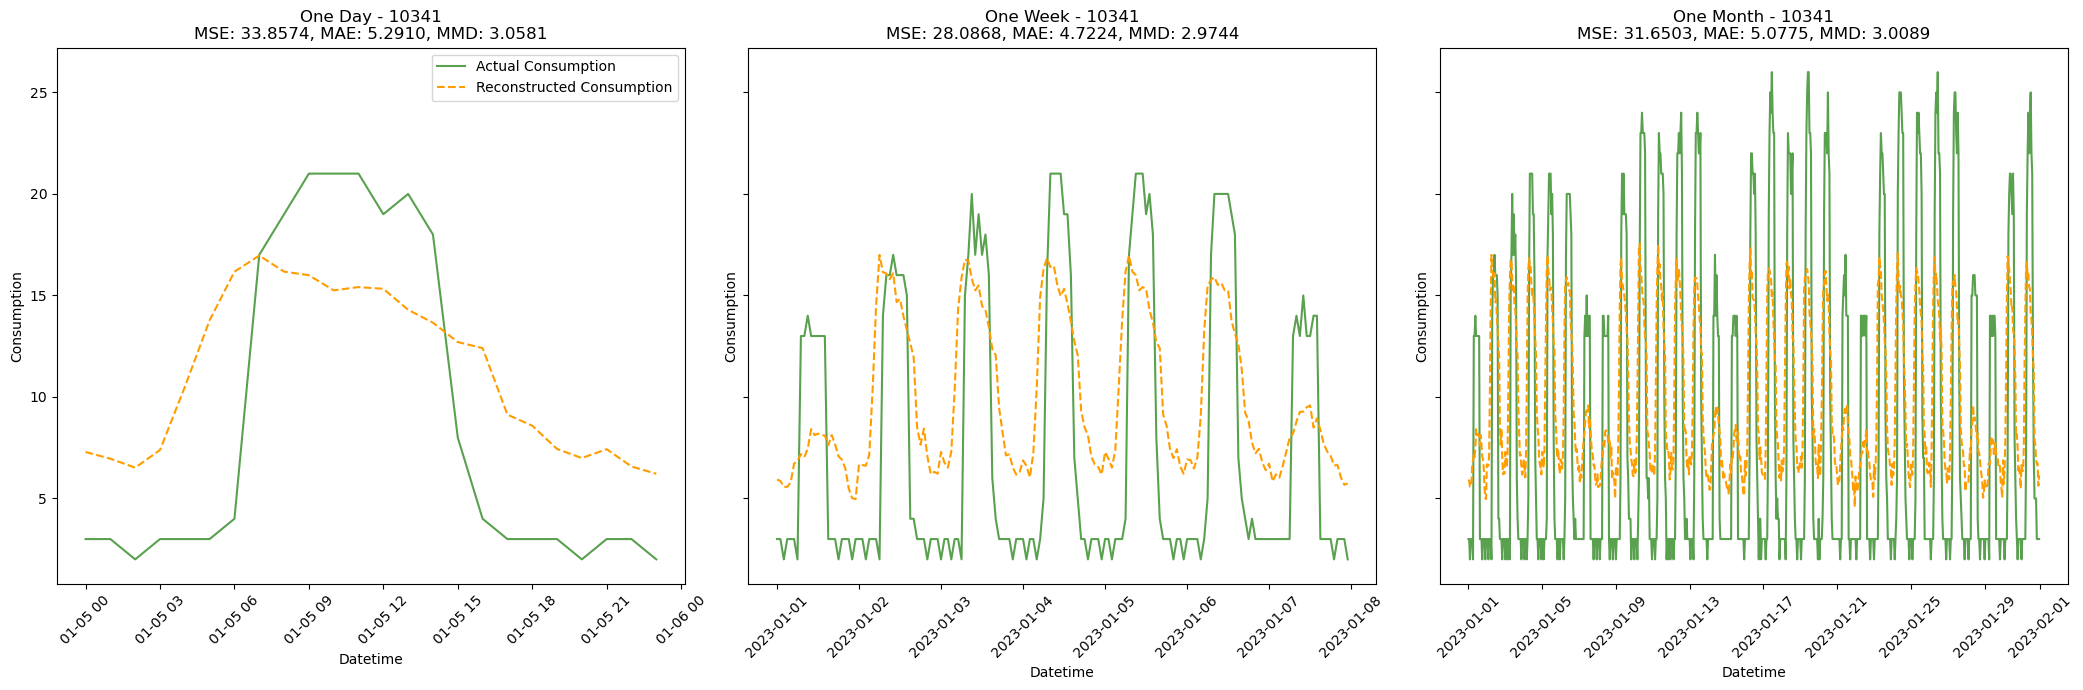

In [93]:
# Define the color palette from the provided image
actual_color = '#59A14F'  # Green
reconstructed_color = '#FF9D00'  # Orange

# Function to compute Maximum Mean Discrepancy (MMD)
def compute_mmd(x, y, sigma_squares=[1, 2, 4, 8, 16]):
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    mmd = 0
    for sigma_square in sigma_squares:
        gamma = 1 / (2 * sigma_square)
        K_XX = torch.exp(-gamma * torch.cdist(x_tensor.unsqueeze(1), x_tensor.unsqueeze(1), p=2))
        K_YY = torch.exp(-gamma * torch.cdist(y_tensor.unsqueeze(1), y_tensor.unsqueeze(1), p=2))
        K_XY = torch.exp(-gamma * torch.cdist(x_tensor.unsqueeze(1), y_tensor.unsqueeze(1), p=2))
        mmd += (K_XX.mean() + K_YY.mean() - 2 * K_XY.mean())
    return mmd.item()

selected_rnd_id = "10341"  # Change this as needed

# Define filters for different time levels
filters = {
    'One Day': (combined_df['month'].isin([1])) & (combined_df['RND_ID'].isin([selected_rnd_id])) & (combined_df['day_of_year'].isin(['005'])),
    'One Week': (combined_df['month'].isin([1])) & (combined_df['RND_ID'].isin([selected_rnd_id])) & (combined_df['day_of_year'].isin([str(i).zfill(3) for i in range(1, 8)])),
    'One Month': (combined_df['month'].isin([1])) & (combined_df['RND_ID'].isin([selected_rnd_id]))
}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharey=True)
axes = axes.flatten()

for i, (title, filter_cond) in enumerate(filters.items()):
    df_selected = combined_df[filter_cond]

    # Select only numeric columns for resampling
    numeric_cols = df_selected.select_dtypes(include=[np.number]).columns
    df_downsampled = df_selected[numeric_cols].resample('h').mean().reset_index()

    # Plot the downsampled data
    if 'consumption_normalized' in df_downsampled.columns:
        # Calculate the error metrics (e.g., MSE, MAE)
        mse = ((df_downsampled['consumption'] - df_downsampled['Reconstructed_Consumption_unnorm']) ** 2).mean()
        mae = (df_downsampled['consumption'] - df_downsampled['Reconstructed_Consumption_unnorm']).abs().mean()
        
        # Calculate MMD
        mmd = compute_mmd(df_downsampled['consumption'], df_downsampled['Reconstructed_Consumption_unnorm'])

        print(f'{title} - MSE: {mse}, MAE: {mae}, MMD: {mmd}')

        # Plot actual vs. reconstructed consumption using the datetime values
        axes[i].plot(df_downsampled['Datetime'].values, df_downsampled['consumption'].values, label='Actual Consumption', color=actual_color)
        axes[i].plot(df_downsampled['Datetime'].values, df_downsampled['Reconstructed_Consumption_unnorm'].values, label='Reconstructed Consumption', linestyle='--', color=reconstructed_color)
        axes[i].set_xlabel('Datetime')
        axes[i].set_ylabel('Consumption')
        axes[i].set_title(f'{title} - {selected_rnd_id}\nMSE: {mse:.4f}, MAE: {mae:.4f}, MMD: {mmd:.4f}')
        axes[i].tick_params(axis='x', rotation=45)

axes[0].legend()
plt.tight_layout()
# Save the plot as a high-resolution image
plt.savefig(image_path + f"reconstructed_consumption_plot_No Attention Yearly Norm_balanced_{selected_rnd_id}.png", dpi=300)
plt.show()

del df_selected
del df_downsampled

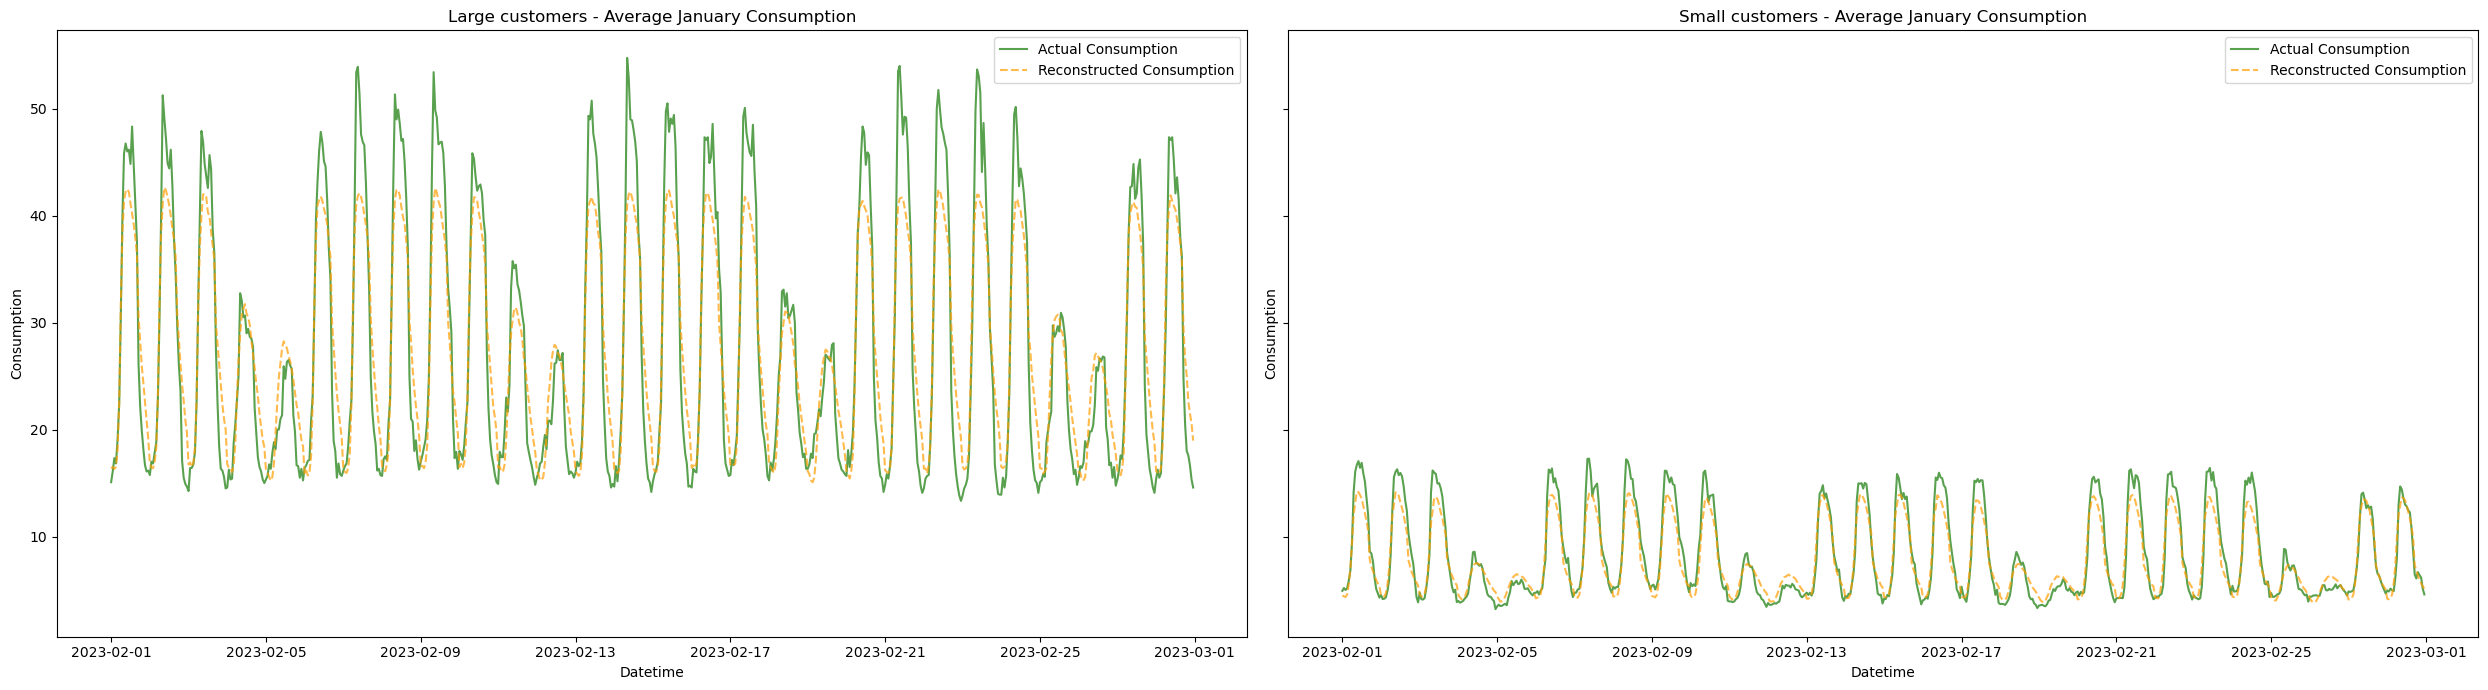

In [7]:
# Define the color palette
actual_color = '#59A14F'  # Green
reconstructed_color_1 = '#FF9D00'  # Orange
reconstructed_color_2 = '#D62828'  # Red
reconstructed_color_3 = '#2D6A4F'  # Dark Green

# Filter for a specific month
month = 2 
monthly_df = combined_df[combined_df['month'] == month]

# Separate large and small customers
large_customers = monthly_df.groupby('RND_ID').filter(lambda x: x['consumption'].mean() > 20)
small_customers = monthly_df.groupby('RND_ID').filter(lambda x: x['consumption'].mean() <= 20)

# Ensure 'datetime' is the index for resampling
large_customers.set_index('Datetime', inplace=True)
small_customers.set_index('Datetime', inplace=True)

# Define a function to resample and plot the data
def plot_customer_data(df, title, ax):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_hourly = df[numeric_cols].resample('h').mean().reset_index()
    ax.plot(df_hourly['Datetime'], df_hourly['consumption'], linestyle='-', color=actual_color, alpha=1, label='Actual Consumption')
    ax.plot(df_hourly['Datetime'], df_hourly['Reconstructed_Consumption_unnorm'], linestyle='--', color=reconstructed_color_1, alpha=0.7, label='Reconstructed Consumption')
    ax.set_title(title)
    ax.set_xlabel('Datetime')
    ax.set_ylabel('Consumption')
    ax.legend()

# Aggregate hourly data for large customers
fig, axes = plt.subplots(1, 2, figsize=(25, 7), sharey=True)
axes = axes.flatten()

# Plot for large customers
plot_customer_data(large_customers, 'Large customers - Average January Consumption', axes[0])

# Plot for small customers
plot_customer_data(small_customers, 'Small customers - Average January Consumption', axes[1])

plt.tight_layout()
# Save the plot as a high-resolution image
plt.savefig(image_path + "reconstructed_consumption_comparison_avg_january.png", dpi=300)
plt.show()

In [104]:
# Define the file path
combined_file_path = os.path.join(processed_path, "updated_combined_reconstructed_denormalised_balanced.csv")
combined_df.to_csv(combined_file_path)

In [3]:
# Read the Saved DataFrame
# Define the file path
combined_file_path = os.path.join(processed_path, "updated_combined_reconstructed_denormalised_balanced.csv")

# Read the DataFrame from the CSV file
combined_df = pd.read_csv(combined_file_path)

C:\Users\20235149\AppData\Local\Temp\ipykernel_39824\3206049802.py:6: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv(combined_file_path)


In [4]:
combined_df['day_of_year'] = combined_df['day_of_year'].astype(int).astype(str).str.zfill(3)

# Extract hour and minute from time_int
combined_df['hour'] = (combined_df['time_int'] // 100).astype(int).astype(str).str.zfill(2)
combined_df['minute'] = (combined_df['time_int'] % 100).astype(int).astype(str).str.zfill(2)

# Create the 'Datetime' column
combined_df['Datetime'] = pd.to_datetime('2023 ' + combined_df['day_of_year'] + ' ' + combined_df['hour'] + ':' + combined_df['minute'], format='%Y %j %H:%M')

# Downsample the data
# combined_df.set_index('Datetime', inplace=True)

#### Visualization of Reconstructed Consumption - per quantile

One Day - Quantile 0 - MSE: 0.5305345802636993, MAE: 0.6475781294791667, MMD: 0.33726966381073
One Week - Quantile 0 - MSE: 0.6760690843956015, MAE: 0.7516655946433533, MMD: 0.4440675973892212
One Month - Quantile 0 - MSE: 0.6594378767901057, MAE: 0.6786125827442876, MMD: 0.3147541284561157


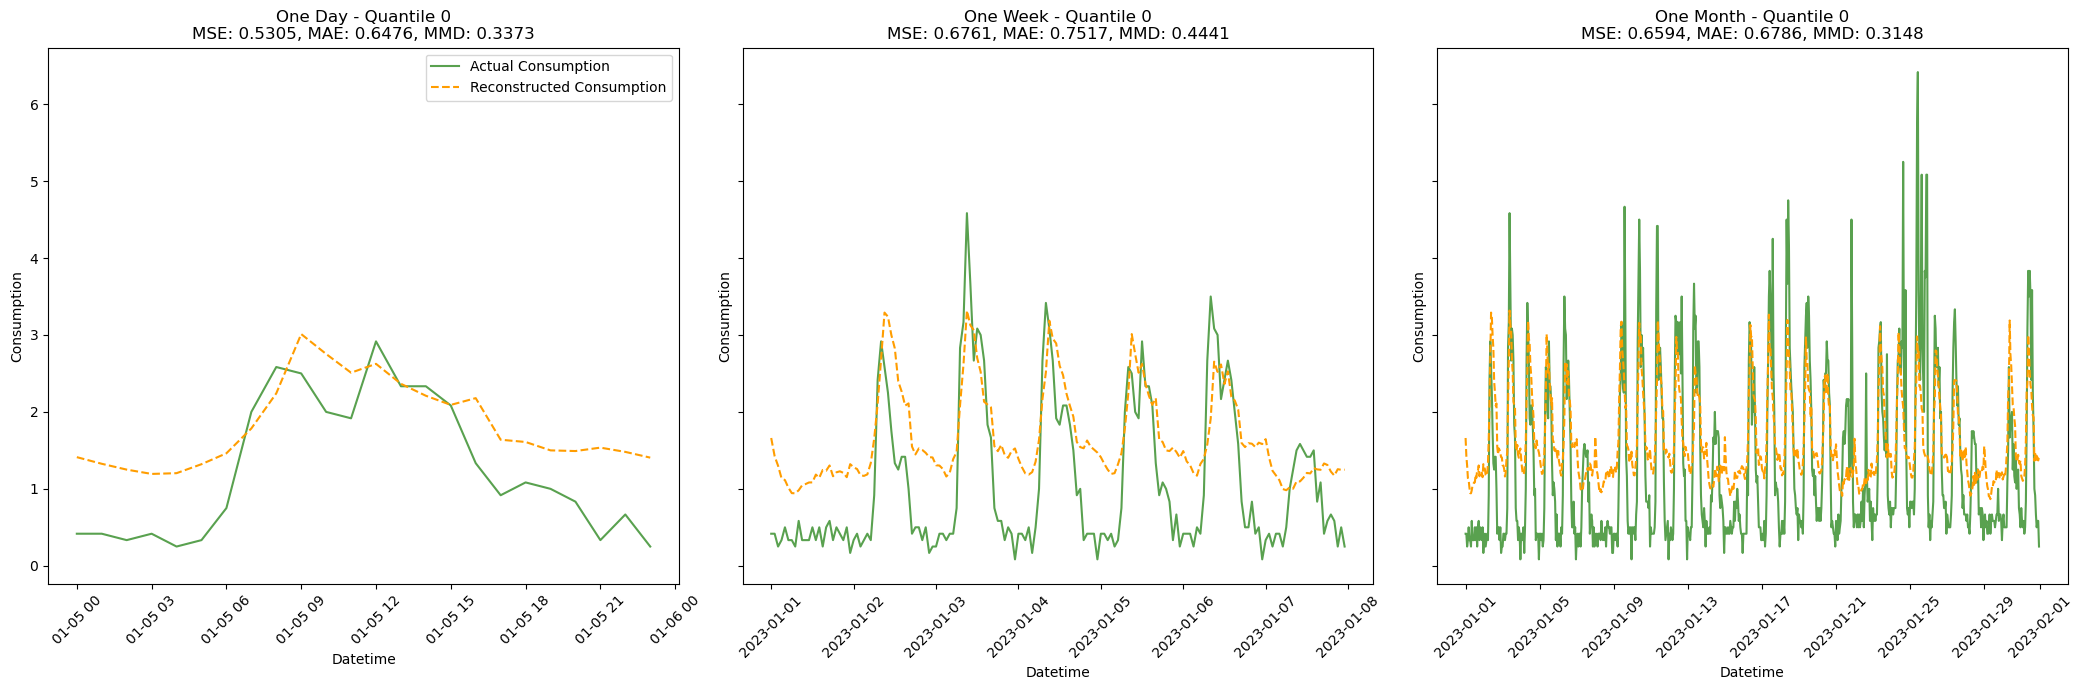

One Day - Quantile 4 - MSE: 26.541451253986565, MAE: 4.445038199255952, MMD: 0.24194079637527466
One Week - Quantile 4 - MSE: 35.28269483017932, MAE: 4.973251514880952, MMD: 0.23870939016342163
One Month - Quantile 4 - MSE: 38.2983240776405, MAE: 5.038583994119624, MMD: 0.2107260376214981


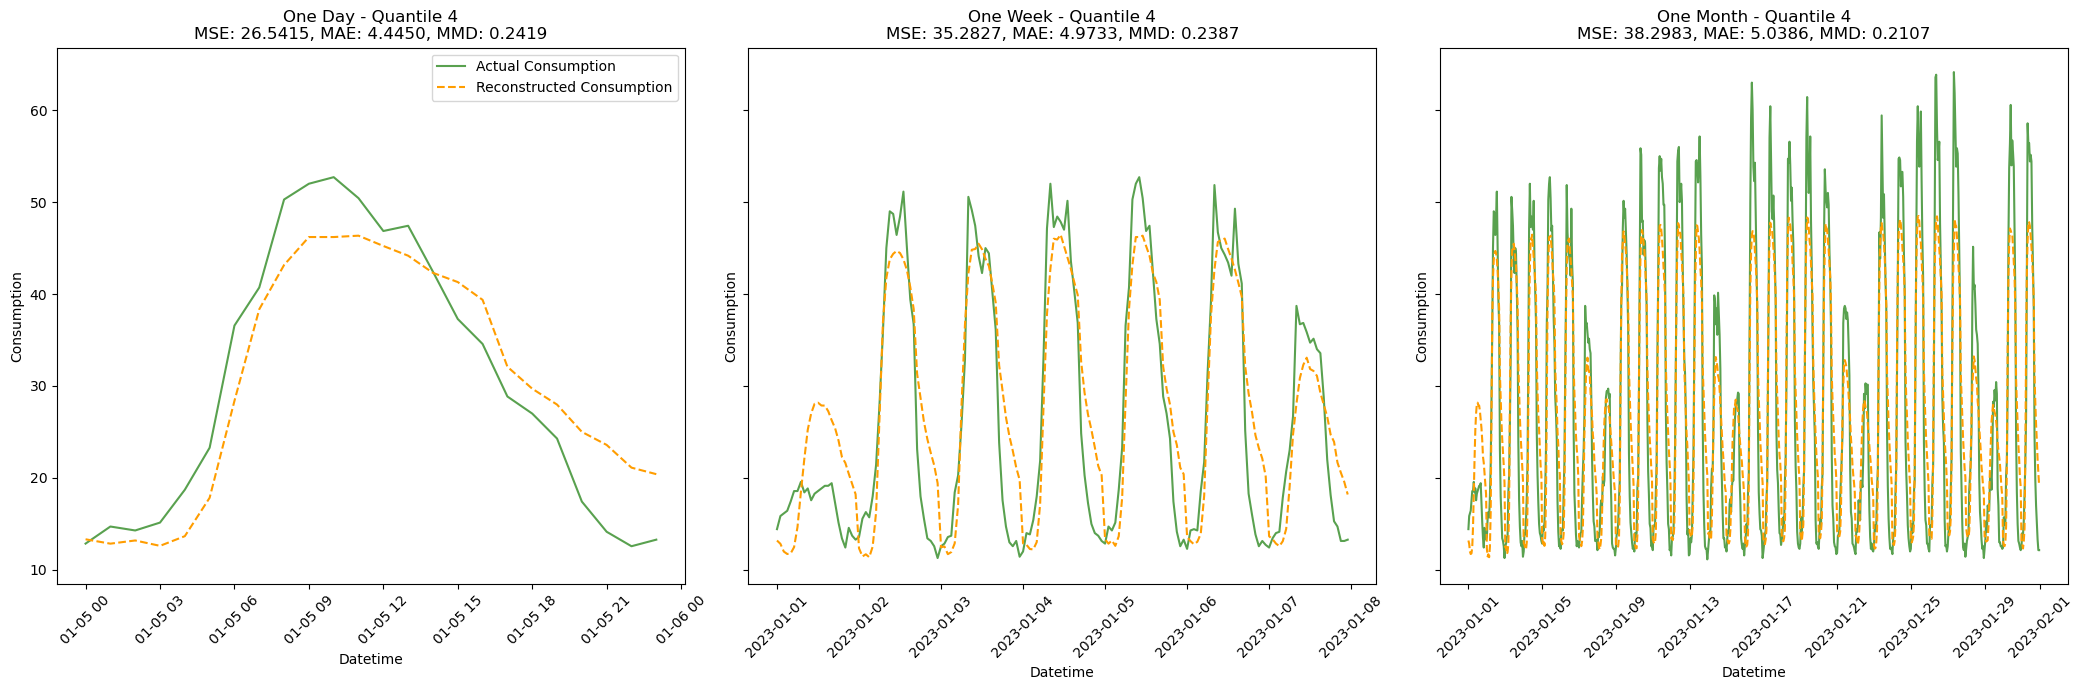

One Day - Quantile 1 - MSE: 4.091482664567802, MAE: 1.366656076909722, MMD: 0.1847691535949707
One Week - Quantile 1 - MSE: 1.7707004185442448, MAE: 0.9535397294022817, MMD: 0.05438131093978882
One Month - Quantile 1 - MSE: 5.689911389344733, MAE: 1.7392184115927418, MMD: 0.11375540494918823


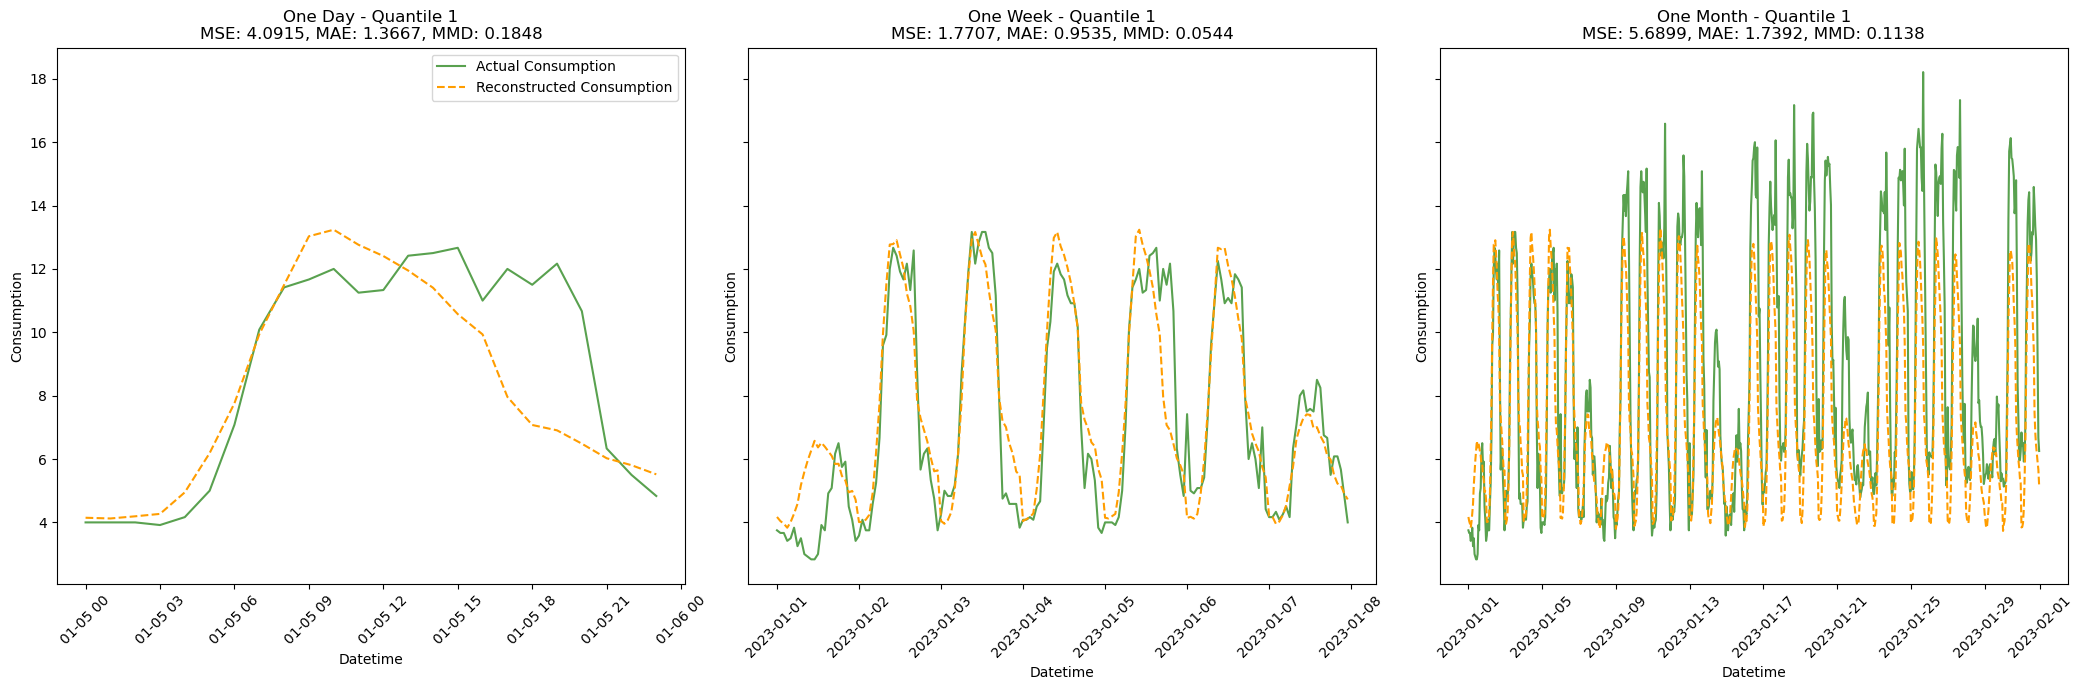

One Day - Quantile 2 - MSE: 6.314589479904144, MAE: 2.251178414814815, MMD: 0.24930056929588318
One Week - Quantile 2 - MSE: 4.457124810251486, MAE: 1.7815652810565477, MMD: 0.14721548557281494
One Month - Quantile 2 - MSE: 5.105493904760438, MAE: 1.7809921712716548, MMD: 0.0719759464263916


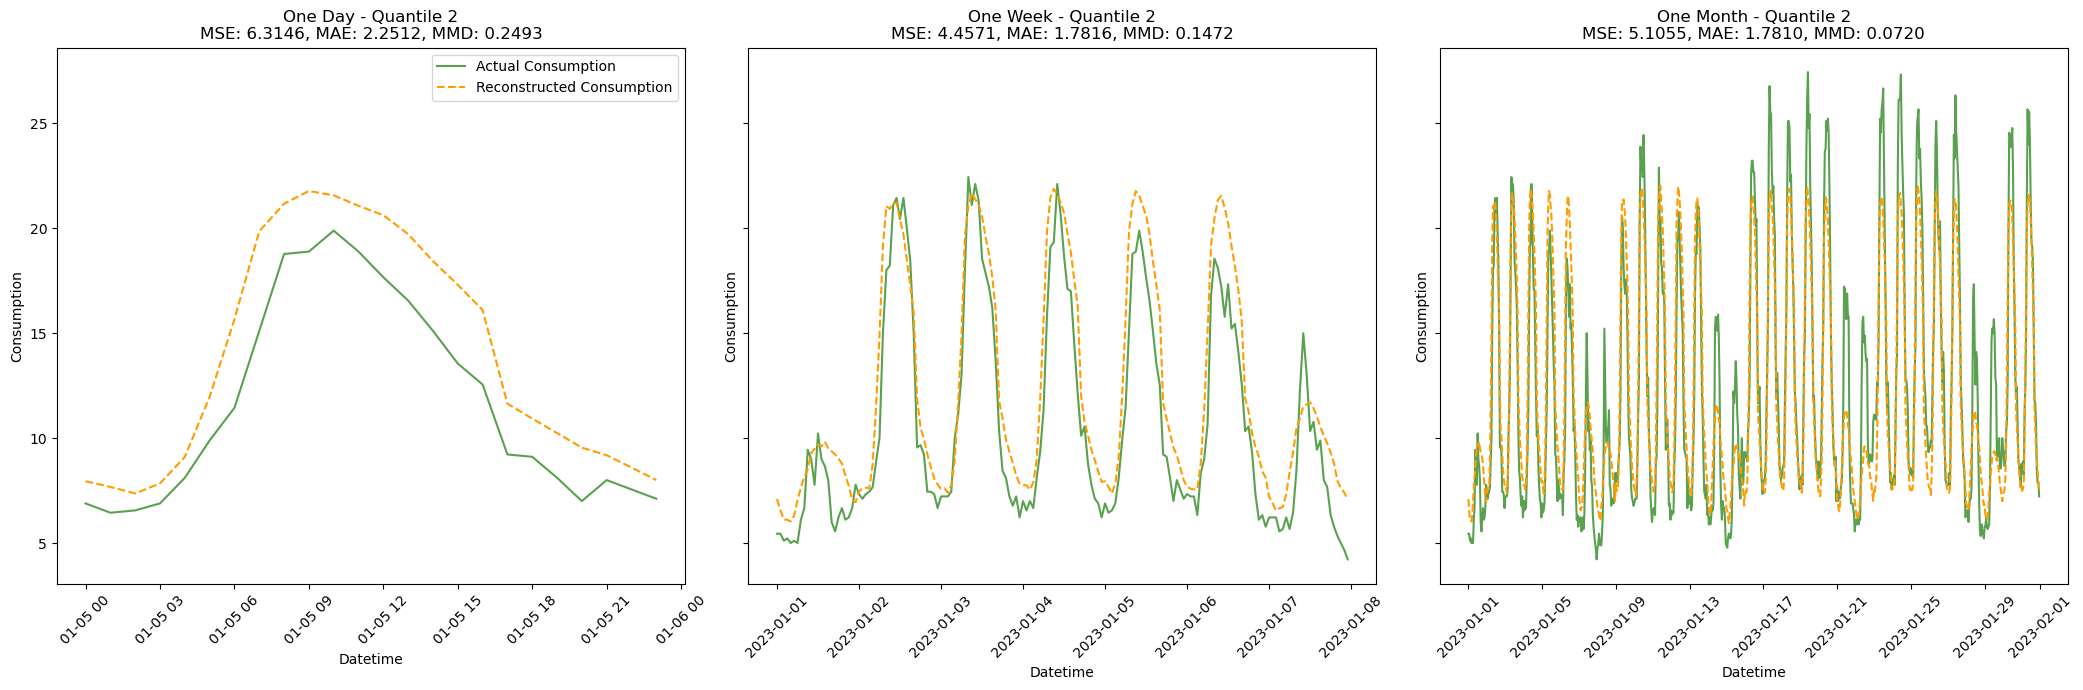

One Day - Quantile 3 - MSE: 12.176941533677885, MAE: 3.077200254583333, MMD: 0.47450411319732666
One Week - Quantile 3 - MSE: 19.45037771455516, MAE: 3.8209101527529765, MMD: 0.5455692410469055
One Month - Quantile 3 - MSE: 17.345232461052948, MAE: 3.2817684496270165, MMD: 0.19548866152763367


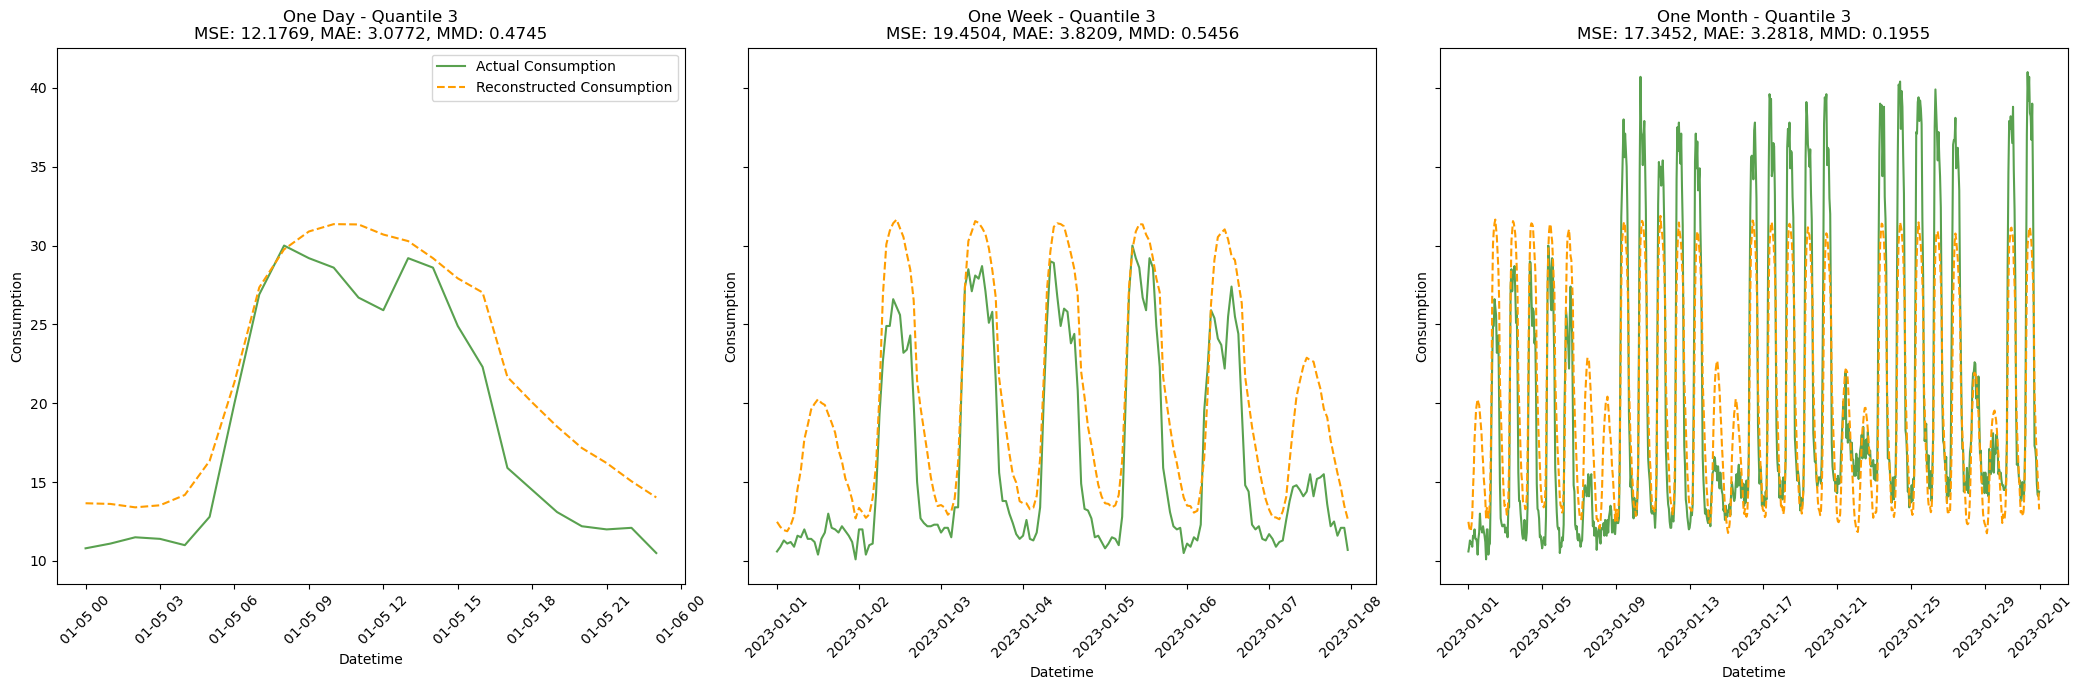

All plots have been generated and saved.


In [23]:
# Define the color palette
actual_color = '#59A14F'  # Green
reconstructed_color = '#FF9D00'  # Orange

# Function to compute Maximum Mean Discrepancy (MMD)
def compute_mmd(x, y, sigma_squares=[1, 2, 4, 8, 16]):
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    mmd = 0
    for sigma_square in sigma_squares:
        gamma = 1 / (2 * sigma_square)
        K_XX = torch.exp(-gamma * torch.cdist(x_tensor.unsqueeze(1), x_tensor.unsqueeze(1), p=2))
        K_YY = torch.exp(-gamma * torch.cdist(y_tensor.unsqueeze(1), y_tensor.unsqueeze(1), p=2))
        K_XY = torch.exp(-gamma * torch.cdist(x_tensor.unsqueeze(1), y_tensor.unsqueeze(1), p=2))
        mmd += (K_XX.mean() + K_YY.mean() - 2 * K_XY.mean())
    return mmd.item()

# Define filters for different time levels
filters = {
    'One Day': (combined_df['month'].isin([1])) & (combined_df['day_of_year'].isin(['005'])),
    'One Week': (combined_df['month'].isin([1])) & (combined_df['day_of_year'].isin([str(i).zfill(3) for i in range(1, 8)])),
    'One Month': (combined_df['month'].isin([1]))
}

# Get unique quantiles
quantiles = combined_df['consumption_quantile'].unique()

for quantile in quantiles:
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharey=True)
    axes = axes.flatten()
    
    for i, (title, filter_cond) in enumerate(filters.items()):
        df_selected = combined_df[(filter_cond) & (combined_df['consumption_quantile'] == quantile)]
        
        # Check if 'Datetime' column exists, if not, create it from the index
        if 'Datetime' not in df_selected.columns:
            if isinstance(df_selected.index, pd.DatetimeIndex):
                df_selected['Datetime'] = df_selected.index
            else:
                print(f"Warning: Unable to create 'Datetime' column for quantile {quantile}")
                continue
        
        # Select only numeric columns for resampling
        numeric_cols = df_selected.select_dtypes(include=[np.number]).columns
        df_downsampled = df_selected.resample('h', on='Datetime')[numeric_cols].mean().reset_index()
        
        # Plot the downsampled data
        if 'consumption' in df_downsampled.columns and 'Reconstructed_Consumption_unnorm' in df_downsampled.columns:
            # Calculate the error metrics
            mse = ((df_downsampled['consumption'] - df_downsampled['Reconstructed_Consumption_unnorm']) ** 2).mean()
            mae = (df_downsampled['consumption'] - df_downsampled['Reconstructed_Consumption_unnorm']).abs().mean()
            
            # Calculate MMD
            mmd = compute_mmd(df_downsampled['consumption'], df_downsampled['Reconstructed_Consumption_unnorm'])
            print(f'{title} - Quantile {quantile} - MSE: {mse}, MAE: {mae}, MMD: {mmd}')
            
            # Plot actual vs. reconstructed consumption
            axes[i].plot(df_downsampled['Datetime'], df_downsampled['consumption'], label='Actual Consumption', color=actual_color)
            axes[i].plot(df_downsampled['Datetime'], df_downsampled['Reconstructed_Consumption_unnorm'], label='Reconstructed Consumption', linestyle='--', color=reconstructed_color)
            axes[i].set_xlabel('Datetime')
            axes[i].set_ylabel('Consumption')
            axes[i].set_title(f'{title} - Quantile {quantile}\nMSE: {mse:.4f}, MAE: {mae:.4f}, MMD: {mmd:.4f}')
            axes[i].tick_params(axis='x', rotation=45)
        else:
            print(f"Warning: Required columns not found for quantile {quantile}")
    
    axes[0].legend()
    plt.tight_layout()
    # Save the plot as a high-resolution image
    plt.savefig(image_path + f"reconstructed_consumption_plot_No_Attention_Yearly_Norm_balanced_Quantile_{quantile}_.png", dpi=300)
    plt.show()
    plt.close(fig)  # Close the figure to free up memory

print("All plots have been generated and saved.")

In [125]:
df_selected['Datetime']

Datetime
2023-01-05 00:00:00   2023-01-05 00:00:00
2023-01-05 00:15:00   2023-01-05 00:15:00
2023-01-05 00:30:00   2023-01-05 00:30:00
2023-01-05 00:45:00   2023-01-05 00:45:00
2023-01-05 01:00:00   2023-01-05 01:00:00
                              ...        
2023-01-05 22:45:00   2023-01-05 22:45:00
2023-01-05 23:00:00   2023-01-05 23:00:00
2023-01-05 23:15:00   2023-01-05 23:15:00
2023-01-05 23:30:00   2023-01-05 23:30:00
2023-01-05 23:45:00   2023-01-05 23:45:00
Name: Datetime, Length: 1152, dtype: datetime64[ns]